# Introduction
This is an initial Explanatory Data Analysis for the Mercari Price Suggestion Challenge with matplotlib. bokeh and Plot.ly - a visualization tool that creates beautiful interactive plots and dashboards. The competition is hosted by Mercari, the biggest Japanese community-powered shopping app with the main objective to predict an accurate price that Mercari should suggest to its sellers, given the item's information.

***Update***: The abundant amount of food from my family's Thanksgiving dinner has really energized me to continue working on this model. I decided to dive deeper into the NLP analysis and found an amazing tutorial by Ahmed BESBES. The framework below is based on his source code. It provides guidance on pre-processing documents and machine learning techniques (K-means and LDA) to clustering topics. So that this kernel will be divided into 2 parts:

1. Explanatory Data Analysis
2. Text Processing  
    1. Tokenizing and tf-idf algorithm
    2. K-means Clustering
    3. Latent Dirichlet Allocation (LDA) / Topic Modelling

In [44]:
import nltk
import string
import re
import numpy as np
import pandas as pd
import pickle
#import lda

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
#from bokeh.transform import factor_cmap

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

# Exploratory Data Analysis
On the first look at the data, besides the unique identifier (item_id), there are 7 variables in this model. This notebook will sequentially go through each of them with a brief statistical summary.
1. Numerical/Continuous Features
    1. price: the item's final bidding price. This will be our reponse / independent variable that we need to predict in the test set
    2. shipping cost
2. Categorical Features
    1. shipping cost: A binary indicator, 1 if shipping fee is paid by seller and 0 if it's paid by buyer
    2. item_condition_id: The condition of the items provided by the seller
    3. name: The item's name
    4. brand_name: The item's producer brand name
    5. category_name: The item's single or multiple categories that are separated by "\"
    6. item_description: A short description on the item that may include removed words, flagged by [rm]

In [9]:
PATH = "../"

In [10]:
train = pd.read_csv(f'{PATH}train.tsv', sep='\t')
test = pd.read_csv(f'{PATH}test.tsv', sep='\t')

In [11]:
# size of training and dataset
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [13]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [10]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [14]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


# Target Variable: Price
The next standard check is with our response or target variables, which in this case is the price we are suggesting to the Mercari's marketplace sellers. The median price of all the items in the training is about \$267 but given the existence of some extreme values of over \$100 and the maximum at \$2,009, the distribution of the variables is heavily skewed to the left. So let's make log-transformation on the price (we added +1 to the value before the transformation to avoid zero and negative values).

In [15]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

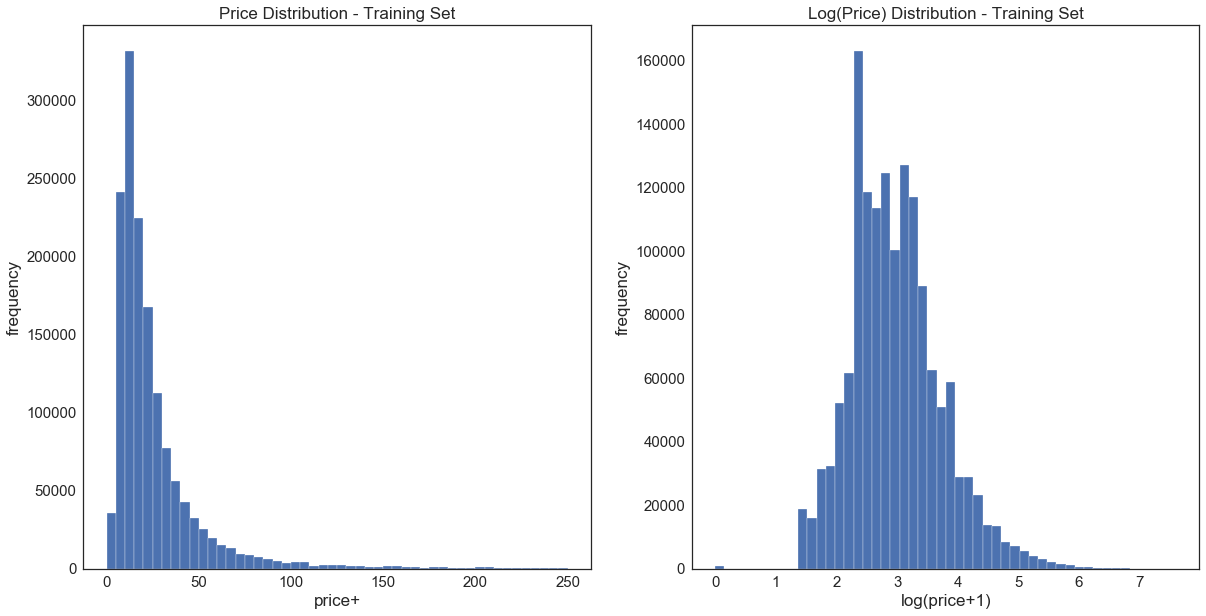

In [16]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

# Shipping
The shipping cost burden is decently splitted between sellers and buyers with more than half of the items' shipping fees are paid by the sellers (55%). In addition, the average price paid by users who have to pay for shipping fees is lower than those that don't require additional shipping cost. This matches with our perception that the sellers need a lower price to compensate for the additional shipping.

In [17]:
train.shipping.value_counts()/len(train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

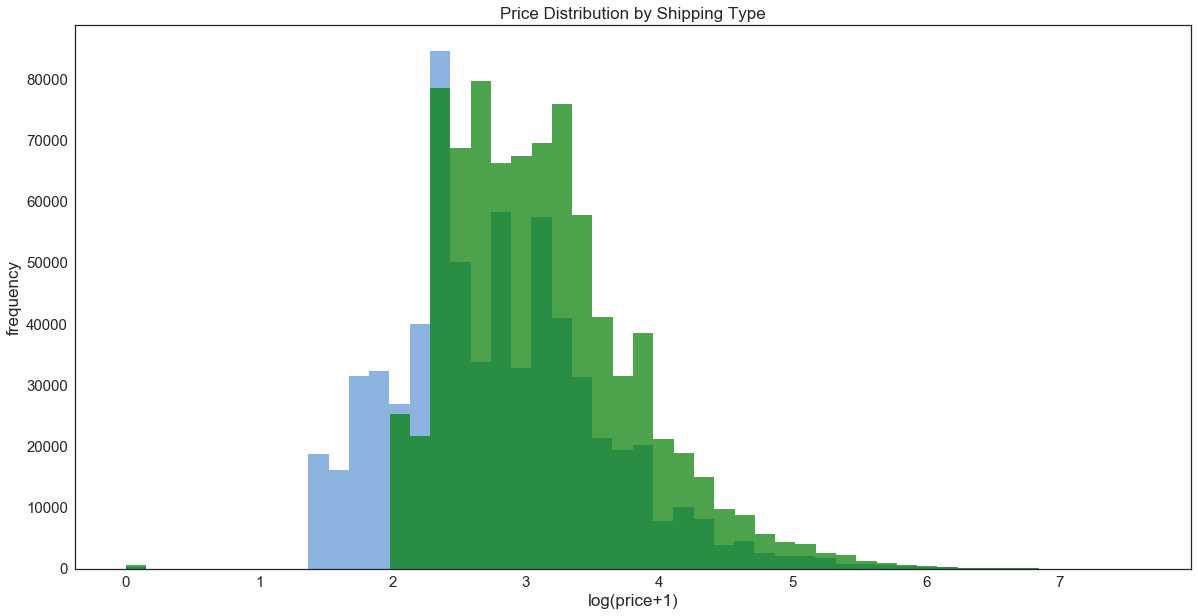

In [18]:
prc_shipBySeller = train.loc[train.shipping==1, 'price']
prc_shipByBuyer = train.loc[train.shipping==0, 'price']
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipBySeller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()

# Item Category
There are about **1,287** unique categories but among each of them, we will always see a main/general category firstly, followed by two more particular subcategories (e.g. Beauty/Makeup/Face or Lips). In adidition, there are about 6,327 items that do not have a category labels. Let's split the categories into three different columns. We will see later that this information is actually quite important from the seller's point of view and how we handle the missing information in the brand_name column will impact the model's prediction.

In [19]:
print("There are %d unique values in the category column." % train['category_name'].nunique())

There are 1287 unique values in the category column.


In [20]:
# TOP 5 RAW CATEGORIES
train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [21]:
# missing categories
print("There are %d items that do not have a label." % train['category_name'].isnull().sum())

There are 6327 items that do not have a label.


In [22]:
# reference: BuryBuryZymon at https://www.kaggle.com/maheshdadhich/i-will-sell-everything-for-free-0-55
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [23]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [28]:
# repeat the same step for the test set
test['general_cat'], test['subcat_1'], test['subcat_2'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))

In [32]:
print("There are %d unique first categories." % train['general_cat'].nunique())

There are 11 unique first categories.


In [29]:
print("There are %d unique first sub-categories." % train['subcat_1'].nunique())

There are 114 unique first sub-categories.


In [30]:
print("There are %d unique second sub-categories." % train['subcat_2'].nunique())

There are 871 unique second sub-categories.


Overall, we have **7 main categories** (114 in the first sub-categories and 871 second sub-categories): women's and beauty items as the two most popular categories (more than 50% of the observations), followed by kids and electronics.

In [31]:
x = train['general_cat'].value_counts().index.values.astype('str')
y = train['general_cat'].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))]

In [35]:
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Number of Items by Main Category', yaxis = dict(title='Count'),xaxis = dict(title='Category'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [36]:
x = train['subcat_1'].value_counts().index.values.astype('str')[:15]
y = train['subcat_1'].value_counts().values[:15]
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))][:15]

In [45]:
trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Number of Items by Sub Category (Top 15)',
              yaxis = dict(title='Count'),
              xaxis = dict(title='SubCategory'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

From the pricing (log of price) point of view, all the categories are pretty well distributed, with no category with an extraordinary pricing point

In [47]:
general_cats = train['general_cat'].unique()
x = [train.loc[train['general_cat']==cat, 'price'] for cat in general_cats]

In [48]:
data = [go.Box(x=np.log(x[i]+1), name=general_cats[i]) for i in range(len(general_cats))]

In [49]:
layout = dict(title="Price Distribution by General Category",
              yaxis = dict(title='Frequency'),
              xaxis = dict(title='Category'))
fig = dict(data=data, layout=layout)
py.iplot(fig)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# Brand Name

In [50]:
print("There are %d unique brand names in the training dataset." % train['brand_name'].nunique())

There are 4809 unique brand names in the training dataset.


In [51]:
x = train['brand_name'].value_counts().index.values.astype('str')[:10]
y = train['brand_name'].value_counts().values[:10]

In [52]:
trace1 = go.Bar(x=x, y=y, 
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Top 10 Brand by Number of Items',
              yaxis = dict(title='Brand Name'),
              xaxis = dict(title='Count'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

# Item Description
It will be more challenging to parse through this particular item since it's unstructured data. Does it mean a more detailed and lengthy description will result in a higher bidding price? We will strip out all punctuations, remove some english stop words (i.e. redundant words such as "a", "the", etc.) and any other words with a length less than 3:

In [53]:
def wordCount(text):
    # convert to lower case and strip regex
    try:
         # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
#         tokenize
#         words = nltk.word_tokenize(clean_txt)
#         remove words in stop words
        words = [w for w in txt.split(" ") \
                 if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except: 
        return 0

In [54]:
# add a column of word counts to both the training and test set
train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))
test['desc_len'] = test['item_description'].apply(lambda x: wordCount(x))

In [55]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,14
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,8
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,14
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3


In [56]:
df = train.groupby('desc_len')['price'].mean().reset_index()

In [57]:
trace1 = go.Scatter(
    x = df['desc_len'],
    y = np.log(df['price']+1),
    mode = 'lines+markers',
    name = 'lines+markers'
)
layout = dict(title= 'Average Log(Price) by Description Length',
              yaxis = dict(title='Average Log(Price)'),
              xaxis = dict(title='Description Length'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

We also need to check if there are any missing values in the item description (4 observations don't have a description) andl remove those observations from our training set.

In [58]:
train.item_description.isnull().sum()

4

In [59]:
# remove missing values in item description
train = train[pd.notnull(train['item_description'])]

In [60]:
# create a dictionary of words for each category
cat_desc = dict()
for cat in general_cats: 
    text = " ".join(train.loc[train['general_cat']==cat, 'item_description'].values)
    cat_desc[cat] = tokenize(text)
# flat list of all words combined
flat_lst = [item for sublist in list(cat_desc.values()) for item in sublist]
allWordsCount = Counter(flat_lst)
all_top10 = allWordsCount.most_common(20)
x = [w[0] for w in all_top10]
y = [w[1] for w in all_top10]

NameError: name 'tokenize' is not defined